## MIPHA Playground

The purpose of this notebook is to test the MIPHA framework with a real use case. A proper "example" package will be provided in a future version, once the framework has stabilized.

The data used in this example has been extracted from the [MIMIC-IV database](https://physionet.org/content/mimiciv/2.2/). The code used to extract the data will also be added to the example package.

In [1]:
from importlib import reload
import sys

import pandas as pd

from src.mipha.framework import *
from tests.playground.implementation import *
from tests.playground.data_manager import *

In [2]:
reload(sys.modules['src.mipha.framework'])
reload(sys.modules['tests.playground.implementation'])
reload(sys.modules['tests.playground.data_manager'])

<module 'tests.playground.data_manager' from 'C:\\Biologie_PhD\\mipha\\tests\\playground\\data_manager.py'>

### Framework implementation

We test a simple implementation of the framework applied to the prediction of stage 5 CKD (using a year of history for a prediction up to 15 months in advance).
The data sources used in this example are:
- The evolution of creatinine over time.
- The age and gender of the patient.

The framework is implemented as such:
- Feature extraction for the first data source is performed using the `tsfel` package.
- Aggregation is a simple concatenation of the extracted features.
- The machine learning model is a simple CNN.

In [3]:
data_sources_train, labels_train, data_sources_test, labels_test = load_stage_5_ckd(random_state=25)

In [4]:
mipha = MiphaPredictor(
    feature_extractors=[BiologyFeatureExtractor(), DemographicsFeatureExtractor()],
    aggregator=SimpleAggregator(),
    model=SimpleCnnModel(rows=1, columns=142, output_dim=1, n_filters=3), # input dimensions are picked for the aggregator, output is binary
    evaluator=SimpleEvaluator(),
)

Compiling the model...
Model compiled!


C:\Biologie_PhD\mipha\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 140, 3)         │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 140, 3)         │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 140, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        13,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,529 (52.85 KB)

 Trainable params: 13,523 (52.82 KB)

 Non-trainable params: 6 (24.00 B)

In [5]:
mipha.fit(data_sources_train, labels_train, epochs=3)

Fitting the model...
Extracting features from data sources...
Imputing data...


  0%|          | 0/10700 [00:00<?, ?it/s]

Data successfully imputed!
*** Feature extraction started ***


C:\Biologie_PhD\mipha\tests\playground\implementation.py:112: UserWarning: Using default sampling frequency set in configuration file.
  extracted_features = tsfel.time_series_features_extractor(config, data_imputed).astype(float)



*** Feature extraction finished ***
Feature extraction complete!
Aggregating features from data sources...
Aggregation complete!
Scaling x_train...
x_train scaled successfully!
Epoch 1/3
359/359 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7778 - loss: 0.4700
Epoch 2/3
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8205 - loss: 0.3986
Epoch 3/3
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8197 - loss: 0.3921
Model fit successfully!
Model fit successfully!


<Sequential name=sequential, built=True>

Extracting features from data sources...
Imputing data...


  0%|          | 0/2703 [00:00<?, ?it/s]

Data successfully imputed!
*** Feature extraction started ***


C:\Biologie_PhD\mipha\tests\playground\implementation.py:112: UserWarning: Using default sampling frequency set in configuration file.
  extracted_features = tsfel.time_series_features_extractor(config, data_imputed).astype(float)



*** Feature extraction finished ***
Feature extraction complete!
Aggregating features from data sources...
Aggregation complete!
Scaling x_test...
x_test scaled successfully!
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 82.09%
ROC-AUC: 80.43%
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1900
           1       0.68      0.76      0.72       803

    accuracy                           0.82      2703
   macro avg       0.79      0.80      0.79      2703
weighted avg       0.83      0.82      0.82      2703



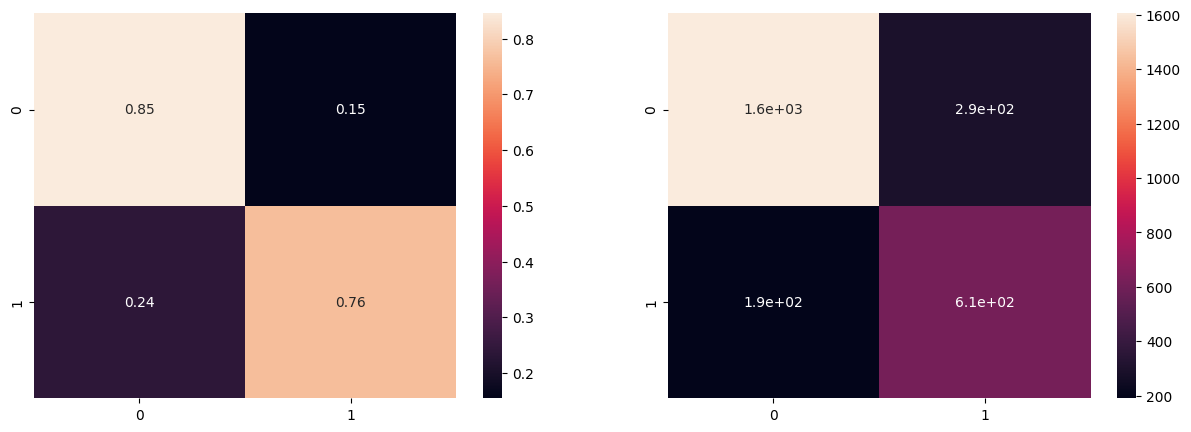

[[0.84526316 0.15473684]
 [0.2366127  0.7633873 ]]


In [6]:
mipha.evaluate(data_sources=data_sources_test, test_labels=pd.DataFrame(labels_test), threshold=0.5)